In [1]:
import os
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

In [2]:
sys.path.append("../../src/.")
import plotting_functions as pf

In [3]:
DIR = "../../data/"
SUBWAYUS = "Subway USA/subway_usa_"

In [4]:
train_df = pd.read_csv(DIR + SUBWAYUS + "processed_train.csv", index_col="store")
test_df = pd.read_csv(DIR + SUBWAYUS + "processed_test.csv", index_col="store")

In [5]:
train_df.shape

(12944, 128)

In [6]:
result_df = pd.DataFrame([], index=train_df.index)

## PCA

### Test for Mininum Components to Capture 90% Variance

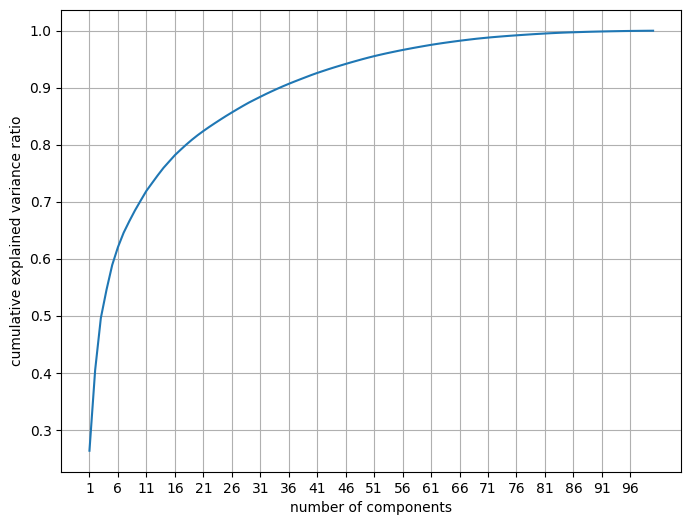

35

In [7]:
pf.pca_plot(train_df)

### PCA model (90% Variance) - Layer 1

In [8]:
pca = PCA(n_components=37, whiten=True, random_state=42)
pca.fit(train_df)

PCA(n_components=37, random_state=42, whiten=True)

In [9]:
transformed_features = pd.DataFrame(
    abs(pca.components_), 
    columns=train_df.columns.tolist(), 
    index=pca.get_feature_names_out(train_df.columns.tolist()))
transformed_features.head()

,occ_wc_p_ta,hhcy_ta,gdp_ta,disposable_inc_avg_ta,hhgrpycy_ta,hh_type_male_child_p_ta,nces_private_schools_total_enrollment_1mi,hh_type_male_nochild_p_ta,age85pl_p_ta,asian_p_ta,...,popcy_ta,transitstop_nearest_dist,com0002_p_ta,edu_bachplus_p_ta,centerxy_gla_effective_5mi,centerxy_gla_effective_1mi,dtpop_children_at_home_p_ta,hispanic_p_ta,market_size,store_density
pca0,0.033010,0.154476,0.141976,0.058692,0.007654,0.024785,0.100784,0.028837,0.027385,0.079065,...,0.145117,0.052738,0.019432,0.077473,0.102458,0.048082,0.023798,0.049028,0.196444,0.184512
pca1,0.018055,0.005979,0.026363,0.207135,0.098581,0.062229,0.009113,0.080570,0.003971,0.073695,...,0.003066,0.053096,0.081847,0.146767,0.020801,0.015972,0.050011,0.037340,0.173871,0.026345
pca2,0.061524,0.031111,0.061669,0.026548,0.068033,0.111821,0.052505,0.154055,0.127792,0.019514,...,0.092455,0.026267,0.155083,0.109790,0.049782,0.013208,0.210357,0.168697,0.205584,0.027271
pca3,0.002016,0.020842,0.057100,0.018302,0.113669,0.012485,0.094567,0.036238,0.133191,0.024766,...,0.026617,0.040984,0.028190,0.100918,0.096003,0.094477,0.108711,0.005013,0.149431,0.107449
pca4,0.031277,0.022307,0.088207,0.007855,0.253157,0.023740,0.056854,0.066205,0.120191,0.026323,...,0.035001,0.110678,0.105847,0.009281,0.105784,0.010810,0.081344,0.032157,0.255061,0.091413


#### Filter and Count Important Features (of heavy weights)

Filter the values in the PCA component matrix, and count the occurrence of the features in the filtered matrix.

In [10]:
W = abs(pca.components_)
features = transformed_features.columns
long_results = []
for i in range(W.shape[0]):
    array = W[i]
    heavy_idx = np.where(array > 0.15)
    long_results += list(features[heavy_idx])

In [11]:
count = pd.Series(long_results).value_counts()
pca_features = count.index.tolist()
count

market_size                                         16
other_p_ta                                          12
occ_unclassified_p_ta                               11
nces_public_schools_nearest_dist                    11
medsalcy_ta                                         10
                                                    ..
hh_type_married_nochild_p_ta                         1
age65pl_p_ta                                         1
crime_total_index_ta                                 1
ipeds_postsecondary_schools_1mi                      1
ipeds_postsecondary_schools_total_enrollment_5mi     1
Name: count, Length: 104, dtype: int64

In [12]:
pca_feature_weight = pd.Series(np.sum(W, axis=0), index=transformed_features.columns)
pca_feature_weight.sort_values(ascending=False, inplace=True)
pca_feature_weight = pca_feature_weight.filter(items = pca_features, axis=0)
pca_feature_weight

market_size                                         4.854782
other_p_ta                                          4.091125
occ_unclassified_p_ta                               4.258495
nces_public_schools_nearest_dist                    4.351657
medsalcy_ta                                         3.529541
                                                      ...   
hh_type_married_nochild_p_ta                        1.820675
age65pl_p_ta                                        1.891914
crime_total_index_ta                                2.068791
ipeds_postsecondary_schools_1mi                     2.320354
ipeds_postsecondary_schools_total_enrollment_5mi    2.030286
Length: 104, dtype: float64

In [13]:
important_features = pca_feature_weight.sort_values(ascending=False)[:40].index.tolist()

In [14]:
reduced_train = train_df[pca_features]
reduced_test = test_df[pca_features]
reduced_train

,market_size,other_p_ta,occ_unclassified_p_ta,nces_public_schools_nearest_dist,medsalcy_ta,transitstop_nearest_dist,inrix_total_ta,nces_private_schools_nearest_dist,osm_nearest_exit_dist,com0811_p_ta,...,hh_inc_gt_500k_p_ta,hhinc30lt_p_ta,medhhinc_ta,hh_type_1pers_p_ta,white_p_ta,hh_type_married_nochild_p_ta,age65pl_p_ta,crime_total_index_ta,ipeds_postsecondary_schools_1mi,ipeds_postsecondary_schools_total_enrollment_5mi
store,,,,,,,,,,,,,,,,,,,,,
6150300,2.0,-0.352255,-0.408704,-0.719608,-1.901959,-0.482508,-0.587414,-0.502267,-0.425379,3.304383,...,-1.001883,1.119108,-0.987171,-0.577592,-1.749451,-0.434997,-0.518491,-0.812085,-0.251734,-0.459608
3784100,2.0,0.213035,-0.319611,0.703190,-1.138936,-0.476755,1.135356,-0.398822,-0.360187,-1.035261,...,-0.536245,-0.271087,-0.238295,-0.636700,0.029789,0.882388,0.620398,-0.612141,-0.251734,-0.215596
1192500,2.0,0.068600,0.045673,-0.398347,1.141680,-0.484816,-0.593298,-0.465102,-0.301741,-0.493172,...,0.102129,-0.381504,0.061521,0.170248,0.457056,0.123936,0.270705,-0.428859,-0.251734,-0.223816
449400,4.0,-0.399570,-0.141424,-0.533603,-0.379378,0.043970,-0.999861,-0.389734,-0.021385,-0.425777,...,-0.641389,0.391411,-0.580699,0.202371,0.363884,-0.126522,0.629952,-0.562155,-0.251734,-0.421761
2292700,0.0,-0.250154,-0.399795,-0.303830,0.122160,-0.483643,2.300364,-0.462221,-0.185947,1.090608,...,0.154701,-0.749558,0.537644,-1.572142,-1.577531,0.266854,-0.743976,0.021015,-0.251734,0.508383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440100,4.0,-0.334823,-0.435432,-0.805969,-0.452116,0.146766,-0.134447,-0.486132,-0.383242,-0.920983,...,-0.769064,0.422959,-0.627722,0.548022,1.167739,0.525803,1.325515,-1.161987,-0.251734,0.561242
6487000,4.0,-0.299959,-0.257245,0.241304,-1.595424,0.812837,0.289174,-0.230307,-0.376830,-0.836007,...,-0.438612,0.333574,-0.536665,0.077731,-0.164352,0.194687,-0.268165,0.837454,-0.251734,-0.197820
2493300,1.0,-0.302450,-0.301792,0.398550,0.543755,-0.336341,-0.142035,-0.393638,-0.320988,1.317699,...,0.042046,-0.211147,0.098217,0.386119,1.018819,-0.173218,0.469438,-0.795423,-0.251734,0.054833


In [15]:
def corr_pair(target_corr, corr_threshold=0.6):
    np.fill_diagonal(target_corr.values, 0)
    sorted_pair = target_corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
    return sorted_pair[sorted_pair > corr_threshold]

correlated_pairs = corr_pair(reduced_train.corr())

In [16]:
correlated_pairs[:20:2]

wealth_hhtotal_ta             hhcy_ta                               1.000000
                              occhu_ta                              1.000000
occhu_ta                      hhcy_ta                               1.000000
popgrpy_ta                    pop5y_cagr_ta                         0.999096
popgrfy_ta                    hhgrfypy_ta                           0.998156
hh_inc_lt_75k_p_ta            hh_inc_gt_75k_p_ta                    0.998023
hhgrpycy_ta                   popgrpy_ta                            0.997022
dtpop_students_p_ta           dtpop_students_post_secondary_p_ta    0.996903
pop5y_cagr_ta                 hhgrpycy_ta                           0.996545
dtpop_students_prek_8th_p_ta  dtpop_children_at_home_p_ta           0.991309
dtype: float64

In [17]:
def corr_pair_drop(feature_pairs, corr_with_target):
    selected, discarded = [], []
    for f1, f2 in feature_pairs:
        if abs(corr_with_target[f1]) < abs(corr_with_target[f2]):
            selected.append(f2)
            discarded.append(f1)
        else:
            selected.append(f1)
            discarded.append(f2)
    final_discarded = set(discarded) - set(selected) 
    return list(final_discarded)

In [18]:
corr_drop_list = corr_pair_drop(correlated_pairs.index, pca_feature_weight)

In [19]:
important_features = list(set(important_features) - set(corr_drop_list))

In [20]:
reduced_train.drop(columns=corr_drop_list, inplace=True)
reduced_test.drop(columns=corr_drop_list, inplace=True)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_90889/1625573170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train.drop(columns=corr_drop_list, inplace=True)
/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_90889/1625573170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test.drop(columns=corr_drop_list, inplace=True)


In [21]:
correlated_pairs = corr_pair(reduced_train.corr())
correlated_pairs[:20:2]

occhu_ta                     wealth_hhtotal_ta               1.000000
                             hhcy_ta                         1.000000
hhcy_ta                      occhu_ta                        1.000000
popgrpy_ta                   pop5y_cagr_ta                   0.999096
hh_inc_gt_75k_p_ta           hh_inc_lt_75k_p_ta              0.998023
popgrpy_ta                   hhgrpycy_ta                     0.997022
hhgrpycy_ta                  pop5y_cagr_ta                   0.996545
dtpop_children_at_home_p_ta  dtpop_students_prek_8th_p_ta    0.991309
disposable_inc_avg_ta        hhinc100pl_p_ta                 0.989117
                             medhhinc_ta                     0.984030
dtype: float64

### PCA model (90% Variance) - Layer 2

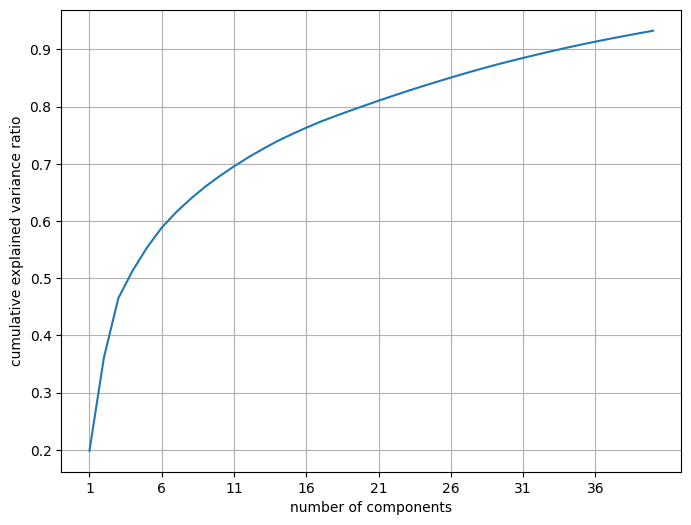

34

In [23]:
pf.pca_plot(reduced_train, 40)

In [24]:
pca_2 = PCA(n_components=34, whiten=True, random_state=42)
pca_2.fit(reduced_train)

PCA(n_components=34, random_state=42, whiten=True)

In [25]:
transformed_features = pd.DataFrame(
    abs(pca_2.components_), 
    columns=reduced_train.columns.tolist(), 
    index=pca_2.get_feature_names_out(reduced_train.columns.tolist()))
transformed_features.head()

,market_size,other_p_ta,occ_unclassified_p_ta,nces_public_schools_nearest_dist,medsalcy_ta,transitstop_nearest_dist,inrix_total_ta,nces_private_schools_nearest_dist,osm_nearest_exit_dist,com0811_p_ta,...,hh_inc_gt_75k_p_ta,hh_inc_gt_500k_p_ta,hhinc30lt_p_ta,medhhinc_ta,hh_type_1pers_p_ta,white_p_ta,hh_type_married_nochild_p_ta,crime_total_index_ta,ipeds_postsecondary_schools_1mi,ipeds_postsecondary_schools_total_enrollment_5mi
pca0,0.343166,0.007120,0.047870,0.046828,0.102251,0.096149,0.077803,0.099403,0.090125,0.059846,...,0.157305,0.166271,0.135129,0.159978,0.018236,0.070019,0.054261,0.026068,0.095273,0.128342
pca1,0.014258,0.006236,0.051089,0.048038,0.026329,0.007668,0.025929,0.031117,0.017374,0.035561,...,0.172349,0.107584,0.179683,0.163231,0.149464,0.120494,0.196130,0.163017,0.087540,0.113060
pca2,0.213678,0.002937,0.000004,0.035386,0.020022,0.020250,0.063462,0.032298,0.052084,0.061029,...,0.022642,0.075762,0.006223,0.034529,0.212787,0.195138,0.039691,0.004311,0.087071,0.028640
pca3,0.165802,0.040563,0.003601,0.007515,0.012907,0.076817,0.040633,0.022111,0.006889,0.098562,...,0.009324,0.013109,0.005852,0.002356,0.019908,0.016891,0.108093,0.105013,0.071067,0.013288
pca4,0.265586,0.025216,0.116421,0.009488,0.007695,0.094512,0.128319,0.152016,0.152581,0.074097,...,0.012469,0.010339,0.031956,0.000633,0.007422,0.030656,0.057799,0.110341,0.207827,0.153849


#### Filter and Count Important Features (of heavy weights)

Filter the values in the PCA component matrix, and count the occurrence of the features in the filtered matrix.

In [26]:
W = abs(pca_2.components_)
features = transformed_features.columns
long_results = []
for i in range(W.shape[0]):
    array = W[i]
    heavy_idx = np.where(array > 0.15)
    long_results += list(features[heavy_idx])

In [27]:
count = pd.Series(long_results).value_counts()
count

occ_bc_p_ta                         14
market_size                         13
occ_unclassified_p_ta               12
nces_public_schools_nearest_dist    11
com0811_p_ta                        11
                                    ..
transitstops                         1
avg_faminc_ta                        1
wealth_hhtotal_ta                    1
hhinc150pl_p_ta                      1
hh_type_married_child_p_ta           1
Name: count, Length: 92, dtype: int64

In [28]:
pca_2_features = count.index.tolist()

In [29]:
pca_2_feature_weight = pd.Series(np.sum(W, axis=0), index=transformed_features.columns)
pca_2_feature_weight.sort_values(ascending=False, inplace=True)
pca_2_feature_weight = pca_feature_weight.filter(items=pca_2_features, axis=0)
pca_2_feature_weight

occ_bc_p_ta                         3.339107
market_size                         4.854782
occ_unclassified_p_ta               4.258495
nces_public_schools_nearest_dist    4.351657
com0811_p_ta                        3.719451
                                      ...   
transitstops                        1.855161
avg_faminc_ta                       1.129029
wealth_hhtotal_ta                   1.336719
hhinc150pl_p_ta                     1.579044
hh_type_married_child_p_ta          1.776772
Length: 92, dtype: float64

In [30]:
pca_2_feature_weight = pca_2_feature_weight.sort_values(ascending=False)
important_features_2 = pca_2_feature_weight[:40].index.tolist()

In [31]:
important_features = list(set(important_features + important_features_2))

In [32]:
reduced_train = reduced_train[important_features]
reduced_test = reduced_test[important_features]
reduced_train

,occ_bc_p_ta,dtpop_unemployed_p_ta,ipeds_postsecondary_schools_total_enrollment_1mi,gq_college_p_ta,black_p_ta,pop_transient_ta,gq_other_p_ta,genz_p_ta,occ_unclassified_p_ta,hh_type_male_nochild_p_ta,...,nces_public_schools_nearest_dist,hrsa_number_of_certified_beds_1mi,centerxy_gla_effective_5mi,hh_type_nonfam_p_ta,dtpop_homemakers_p_ta,nces_private_schools_total_enrollment_1mi,dtpop_students_p_ta,com0811_p_ta,hh_type_male_child_p_ta,genx_p_ta
store,,,,,,,,,,,,,,,,,,,,,
6150300,-0.418402,1.294902,-0.206017,-0.489416,-0.325387,-0.251278,2.510505,0.185124,-0.408704,0.567561,...,-0.719608,-0.254175,-0.659887,-1.109287,1.572029,0.143738,-0.116104,3.304383,1.104476,-0.906808
3784100,0.375126,0.353116,-0.206017,0.809466,0.081633,-0.251278,1.338613,-0.207241,-0.319611,0.502734,...,0.703190,-0.254175,0.346080,-0.371554,1.153955,-0.252705,-0.096388,-1.035261,-0.646358,-0.607775
1192500,0.540203,0.612588,-0.206017,-0.489416,-0.472435,-0.144587,-0.744864,-0.469702,0.045673,0.106573,...,-0.398347,-0.254175,-0.346036,0.366179,-0.396189,0.076759,-0.535503,-0.493172,-0.410199,0.216588
449400,-0.273598,0.429997,-0.206017,-0.489416,-0.546890,-0.207535,-0.151132,-0.183381,-0.141424,0.517140,...,-0.533603,0.352885,-0.498695,0.143518,-0.200056,0.225199,-0.302504,-0.425777,0.208701,-0.236003
2292700,0.307068,0.775959,-0.206017,2.438509,-0.654849,-0.234207,-0.471355,0.177171,-0.399795,1.431912,...,-0.303830,0.796798,0.834463,-0.645186,0.978467,0.308470,0.337349,1.090608,-0.304334,-0.058199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440100,-0.151962,0.180135,-0.206017,-0.489416,-0.551233,-0.213936,-0.682918,-0.649978,-0.435432,-0.476864,...,-0.805969,-0.254175,-0.540838,-0.103288,-0.220701,-0.129609,-0.562388,-0.920983,-0.336908,-0.139019
6487000,0.159367,-0.905801,-0.206017,1.539571,1.251193,0.274174,-0.743172,0.357447,-0.257245,0.012935,...,0.241304,-0.254175,0.085553,-0.578119,-0.342855,-0.341407,0.498657,-0.836007,0.404143,-0.029913
2493300,-0.548726,0.324286,-0.206017,-0.489416,-0.649885,-0.183262,-0.614203,-0.649978,-0.301792,-0.188747,...,0.398550,-0.254175,0.113689,1.028797,-0.740283,-0.229172,-0.558803,1.317699,-0.157753,0.353982


In [33]:
def corr_pair(target_corr, corr_threshold=0.6):
    np.fill_diagonal(target_corr.values, 0)
    sorted_pair = target_corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
    return sorted_pair[sorted_pair > corr_threshold]

correlated_pairs = corr_pair(reduced_train.corr())

In [34]:
correlated_pairs[:20:2]

nces_private_schools_total_enrollment_1mi  nces_private_schools_1mi    0.822156
emp_p_ta                                   dtpop_homemakers_p_ta       0.643946
dtype: float64

In [41]:
print(pca_feature_weight['nces_private_schools_total_enrollment_1mi'], pca_feature_weight['nces_private_schools_1mi'])
print(pca_feature_weight['emp_p_ta'], pca_feature_weight['dtpop_homemakers_p_ta'])

3.210843295975736 2.9374874658527874
2.5660558269581375 3.392289517731649


In [42]:
corr_drop_list = ['nces_private_schools_1mi', 'dtpop_homemakers_p_ta']

In [43]:
reduced_train.drop(columns=corr_drop_list, inplace=True)
reduced_test.drop(columns=corr_drop_list, inplace=True)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_90889/1625573170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train.drop(columns=corr_drop_list, inplace=True)


In [47]:
correlated_pairs = corr_pair(reduced_train.corr())
correlated_pairs

Series([], dtype: float64)